In [1]:
from matplotlib import pyplot as plt

from src.common.log import logger
from src.common.paths import PlotPaths
from src.dataset.tno_dataset_collection import TnoDatasetCollection
from src.inverse_problems.compressed_sensing_problem import SectorWiseCompressedSensingProblem
from src.inverse_problems.inverse_problems_solver import GenerativeModelSolver
from src.models.common.metrics import ssim, relative_error
from src.plotting.city_emission_field_plot import plot_emission_field_tensor

In [2]:
dataset_collection = TnoDatasetCollection()

[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2015_highres_by_city.csv'
[INFO] > Loading TNO data from '/home/must1d/Repositories/inventory-embeddings/data/TNO-GHGco-1km/TNO_by_city/TNO_GHGco_2018_highres_by_city.csv'
[INFO] > Test Set has 13 unique cites!                           
	Dresden, Hamburg, Prague, Siegen, Győr, Aachen, Szczecin, Magdeburg, Gdynia, Großzschocher, Duisburg, Reims, Innsbruck
[INFO] > Validation Set has 15 unique cites!
	Bielefeld, Kalisz, Southampton, Bydgoszcz, Ingolstadt, Kassel, Wałbrzych, Brussels, Linz, Angers, Koblenz, Nijmegen, Zielona Góra, Frankfurt am Main, Erfurt
[INFO] > Training Set has 74 unique cites!
	Braunschweig, Saint Peters, Dijon, Nancy, Chemnitz, Metz, Rostock, Breda, Opole, Milton Keynes, Berlin, Brugge, Brighton, Münster, Strasbourg, Sheffield, Mannheim, Leeds, Rotterdam, Tours, Orléans, Nürnberg, Wrocław, Nantes, Karlsruhe, Kiel, Amsterdam, Regensburg, Ulm, Heilb

In [3]:
CITY = "Zürich"
CITY_LOWER = CITY.lower()

In [4]:
gen_2048 = GenerativeModelSolver.from_vae_model_name("2048", plot_loss=True)
gen_2048_fine_tuned = GenerativeModelSolver.from_vae_model_name(f"2048_{CITY_LOWER}", plot_loss=True)

In [5]:
city_data = dataset_collection.get_single_case_study_city_emission_field(city=CITY, year=2018)
x = city_data.co2_ff_area_sources_tensor

vmax = x.sum(0).max() * 1.1

In [6]:
path = PlotPaths.PLOTS / "sector_wise_reconstruction_example" / CITY_LOWER
path.mkdir(exist_ok=True, parents=True)

In [7]:
snr_db = 20
num_measurements = 5_000

problem = SectorWiseCompressedSensingProblem.generate_random_sector_wise_measurements(
    x=x,
    num_measurements=num_measurements,
    snr=10 ** (snr_db / 10),
)

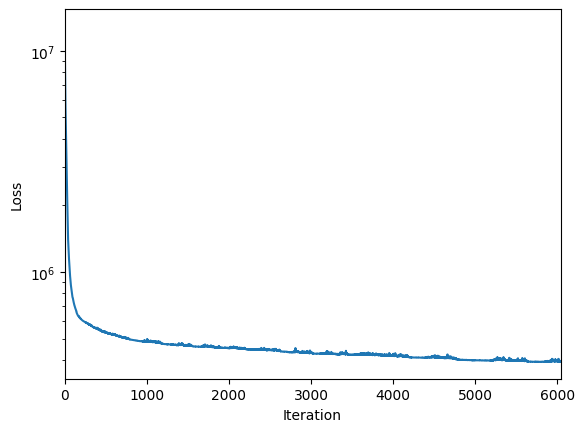

In [8]:
x_rec = problem.solve(gen_2048)

In [9]:
logger.info(f"SSIM={ssim(x, x_rec):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec):.3f}%")

[INFO] > SSIM=0.948
[INFO] > Relative Error=20.797%


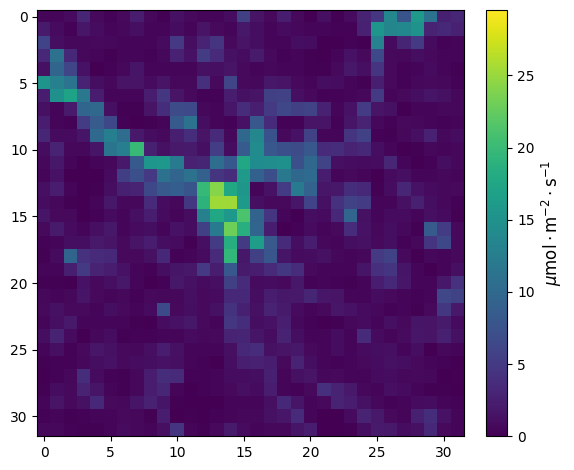

In [10]:
_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec, vmax=vmax)

plt.tight_layout()
plt.savefig(path / f"gen_model_m_{num_measurements}_snr_{snr_db}_db.eps", format="eps", bbox_inches="tight")

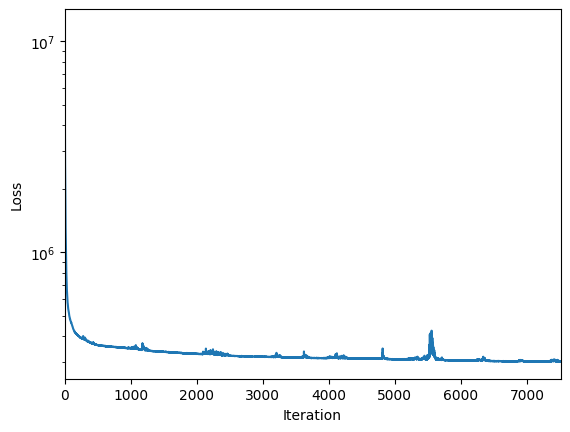

In [11]:
x_rec_fine_tuned = problem.solve(gen_2048_fine_tuned)

In [12]:
logger.info(f"SSIM={ssim(x, x_rec_fine_tuned):.3f}")
logger.info(f"Relative Error={100 * relative_error(x, x_rec_fine_tuned):.3f}%")

[INFO] > SSIM=0.884
[INFO] > Relative Error=17.401%


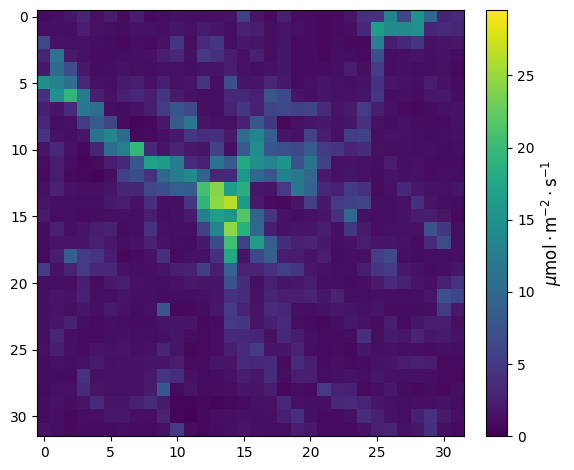

In [13]:
_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x_rec_fine_tuned, vmax=vmax)

plt.tight_layout()
plt.savefig(path / f"gen_model_fine_tuned_m_{num_measurements}_snr_{snr_db}_db.eps", format="eps", bbox_inches="tight")

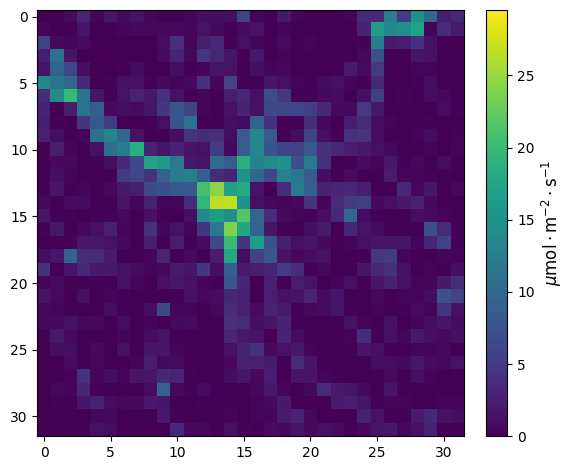

In [16]:
_, ax = plt.subplots()
plot_emission_field_tensor(ax=ax, emission_field=x, vmax=vmax)

plt.tight_layout()
plt.savefig(path / "target.eps", format="eps", bbox_inches="tight")